**TASK THREE**

In [519]:
import sys
!conda install --yes --prefix {sys.prefix} seaborn

In [530]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import urllib

import geopy
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns #beautiful graphs

import folium # map rendering library

from IPython.display import Image

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [17]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(location)
print('The geograpical coordinates are {}, {}.'.format(latitude, longitude))

C:\Users\Roman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


Toronto, Golden Horseshoe, Ontario, M5H 2N2, Canada
The geograpical coordinates are 43.6534817, -79.3839347.


Getting postal codes and corresponding neighborhoods:

In [18]:
codes = pd.read_csv('codes_res.csv')
codes = codes.rename(columns = {'PostalCode':'postal_code','Neighbourhood':'Neighborhood'})
codes.head()

,postal_code,Borough,Neighborhood,Latitude,Longitude
0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648165,-79.379390
1,M2K,North York,Bayview Village,43.777490,-79.380620
2,M6S,West Toronto,"Runnymede, Swansea",43.649990,-79.479589
3,M1G,Scarborough,Woburn,43.769552,-79.217702
4,M6G,Downtown Toronto,Christie,43.668548,-79.420849


In [19]:
neighborhoods = codes

#### Creating a map with neighborhoods superimposed on top.

In [356]:
# create map of Toronto using latitude and longitude values
map_tn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'],\
                                           neighborhoods['Longitude'],\
                                           neighborhoods['Borough'],\
                                           neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tn)  
    
map_tn

#### Define Foursquare Credentials and Version

In [521]:
CLIENT_ID = 'QSMVXKWV3MV1IH2EZEIORSW2MATY1F4531XDKD53OJ31TPPC' # your Foursquare ID
CLIENT_SECRET = 'BMESYFTXEQXNKHLNWIT4QH4DIICCT5HP42E4EHVHO1XFYDWU' # your Foursquare Secret
VERSION = '20200520' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QSMVXKWV3MV1IH2EZEIORSW2MATY1F4531XDKD53OJ31TPPC
CLIENT_SECRET:BMESYFTXEQXNKHLNWIT4QH4DIICCT5HP42E4EHVHO1XFYDWU


#### Let's explore the first postal code in the dataframe.

In [525]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_code = neighborhoods.loc[0, 'postal_code'] # neighborhoods' postal code

neighborhoods_names = neighborhoods.loc[0, 'Neighborhood'] # neighborhoods' names

print('Latitude and longitude of\n{} neighborhoods are: \n{} (lat), \n{} (lon).\nThe postal code is {}'.format(neighborhoods_names,
                                                                                        neighborhood_latitude, 
                                                                                        neighborhood_longitude,
                                                                                        neighborhood_code))

Latitude and longitude of
Commerce Court, Victoria Hotel neighborhoods are: 
43.648165000000006 (lat), 
-79.37939 (lon).
The postal code is M5L


#### Now, let's get venues in the neighborhoods

First, let's create the GET request URL.

In [358]:
radius=2000
LIMIT=100 #max limit of the old API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QSMVXKWV3MV1IH2EZEIORSW2MATY1F4531XDKD53OJ31TPPC&client_secret=BMESYFTXEQXNKHLNWIT4QH4DIICCT5HP42E4EHVHO1XFYDWU&v=20200605&ll=43.705406,-79.553703&radius=5000&limit=100'

In [359]:
results = requests.get(url).json()

We know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pukka Restaurant,Indian Restaurant,43.681055,-79.429187
1,Wychwood Barns,Event Space,43.680028,-79.423810
2,Fiesta Farms,Grocery Store,43.668471,-79.420485
3,Blood Brothers Brewing,Brewery,43.669944,-79.436533
4,CocoaLatte,Café,43.681768,-79.425158


And how many venues were returned by Foursquare?

In [56]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Toronto

Approach:

1. For every neighborhood, retrieve all venues within 2000m of the specified coordinates from Foursquare using the 'explore' endpoint of the API. This will most likely result in reaching the API's limit of search results quantity (and some venues within the radius will be omitted). Then, decrease the search radius several times until the quantity of results is below the limit, and append newly found venues to the results. Thus we make sure to get as many venues in each neighborhood as possible.

2. Then, use the 'search' endpoint of the API to get more venues for the neighborhoods.

3. Combine results, and also add venues which were found earlier and saved into a file (while working in this project).

4. Get rid of duplicated venues which are going to appear because search areas will overlap.

5. Finally, get actual postal codes and neighborhoods for the venues. As a consequence of using large search radii, some retrieved venues for a given neighborhood may in fact lie in another neighborhood or even outside Toronto, so we need to make sure neighborhoods and postal codes are correct for each venue.

In [526]:
#retrieving venues using 'explore' endpoint

def get_nearby_venues(nh,\
    latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    
    for nh, lat, lng in zip(nh, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
        except:
            print('error getting venues for ', nh)
        
            
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                nh,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
            print('{}: {} venues retrieved'.format(nh, len(results)))
            
        except:
            pass

    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    except:
        nearby_venues = pd.DataFrame(columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                                                'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
    
    return(nearby_venues)

#### Now running the above function on each neighborhood and creating a new dataframe called *toronto_venues*.

In [528]:
explore_api_venues = pd.DataFrame()

explore_api_venues = get_nearby_venues(nh=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius = 2000
                                  )

Commerce Court, Victoria Hotel: 100 venues retrieved
Bayview Village: 85 venues retrieved
Runnymede, Swansea: 96 venues retrieved
Woburn: 73 venues retrieved
Christie: 100 venues retrieved
Upper Rouge: 6 venues retrieved
The Beaches: 100 venues retrieved
Downsview: 34 venues retrieved
Willowdale: 100 venues retrieved
Clarks Corners, Tam O'Shanter, Sullivan: 92 venues retrieved
Church and Wellesley: 100 venues retrieved
Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East: 100 venues retrieved
Forest Hill North & West: 100 venues retrieved
Caledonia-Fairbanks: 100 venues retrieved
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport: 100 venues retrieved
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West: 100 venues retrieved
Glencairn: 100 venues retrieved
Central Bay Street: 100 venues retrieved
Hillcrest Vi

In [543]:
explore_api_venues.shape

(8614, 7)

The documented limit of search results quantity is 100. Thus, if for a given code 100 venues were returned, it means there could me more venues in the search radius which were omitted. Therefore, for neighborhoods with 100 venues or more, let's descrease the search radius and look for more venues.

In [544]:
def get_popular_nh(df):
    
    #returns a dataframe with neighborhoods which have 100 venues
    #input: dataframe with result of get_nearby_venues
    
    popular_nh = df.groupby('Neighborhood').count()[['Venue']].reset_index()
    
    popular_nh = popular_nh[popular_nh['Venue'] >= 100]['Neighborhood'].tolist()
    
    print('There are {} neighborhoods for which we need to request venues within smaller radius.'.format(len(popular_nh)))
    popular_nh = neighborhoods.loc[neighborhoods['Neighborhood'].isin(popular_nh),:]
    
    return popular_nh

In [545]:
popular_nh = get_popular_nh(explore_api_venues)

There are 57 neighborhoods for which we need to request venues within smaller radius.


In [546]:
popular_nh_venues = pd.DataFrame(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])

Let's try radii of 1000m, 500m and 100m.

In [547]:
for radius in [1000, 500, 100]:
    
    if popular_nh.shape[0] > 0:
        new_popular_nh_venues = get_nearby_venues(\
                                       nh = popular_nh['Neighborhood'],\
                                       latitudes = popular_nh['Latitude'],\
                                       longitudes = popular_nh['Longitude'],\
                                       radius = radius)
        
        popular_nh = get_popular_nh(new_popular_nh_venues)
        
        popular_nh_venues = popular_nh_venues.append(new_popular_nh_venues, ignore_index=True)
        
        print('-------- new iteration -----------')
        
    else:
        print('All neighborhoods have less then 100 venues in the last iteration.')
        break

Commerce Court, Victoria Hotel: 100 venues retrieved
Christie: 100 venues retrieved
The Beaches: 66 venues retrieved
Downsview: 8 venues retrieved
Willowdale: 100 venues retrieved
Church and Wellesley: 100 venues retrieved
Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East: 22 venues retrieved
Forest Hill North & West: 48 venues retrieved
Caledonia-Fairbanks: 28 venues retrieved
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport: 100 venues retrieved
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West: 66 venues retrieved
Glencairn: 40 venues retrieved
Central Bay Street: 100 venues retrieved
Davisville North: 100 venues retrieved
Parkdale, Roncesvalles: 90 venues retrieved
Richmond, Adelaide, King: 100 venues retrieved
Little Portugal, Trinity: 100 venues retrieved
Don Mills: 31 venues retrieved
Davisvill

In [548]:
explore_api_venues = explore_api_venues.append(popular_nh_venues, ignore_index=True)

Now let's use 'search' endpoint of the API.

In [549]:
search_api_venues =  pd.DataFrame(columns = explore_api_venues.columns)

In [550]:
def get_new_venues(nh, nh_lat, nh_lng, radius = 500):
    
    '''
    
    Uses 'search' endpoint (Places API).
    it's unclear how the API processes the 'radius' parameter. Possibly, it first returns venues within the specified radius
    and then adds more venues in vicinity to add up to the specified limit.
    
    input: coordinates, search radius in meters.
    output: dataframe with venues details.
    
    '''
    
    version = '20200520'
    
    
    url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&client_id={}&client_secret={}&v={}&intent=browse&radius={}&limit=200'.format(nh_lat, nh_lng,\
                                                                                                      client_id,\
                                                                                                      client_secret,\
                                                                                                      version,\
                                                                                                      radius)
    results = requests.get(url).json()
    
    new_venues = pd.DataFrame(columns = ['Venue','Neighborhood', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'postal_code'])
    
    for i in range(len(results['response']['venues'])):
        
        try:
            name = results['response']['venues'][i]['name']
        except:
            name = np.nan
            
        try:
            category = results['response']['venues'][i]['categories'][0]['name']
        except:
            category = np.nan
            
        try:
            lat = results['response']['venues'][i]['location']['labeledLatLngs'][0]['lat']
            lng = results['response']['venues'][i]['location']['labeledLatLngs'][0]['lng']
            
        except:
            lat = np.nan
            lng = np.nan
            
        try:
            postal_code = results['response']['venues'][i]['location']['postalCode'].split(' ')[0]
            
        except:
            postal_code = np.nan
            
        new_venues = new_venues.append({'Neighborhood':nh,\
                                        'Neighborhood Latitude': nh_lat,\
                                        'Neighborhood Longitude': nh_lng,\
                                        'Venue':name,\
                                        'Venue Latitude':lat,\
                                        'Venue Longitude':lng,\
                                        'Venue Category':category,\
                                        'postal_code':postal_code}, ignore_index=True)

        
    print(i+1, ' venues found: ', nh_lat, ', ', nh_lng)
        
    return new_venues

In [551]:
for i in range(neighborhoods.shape[0]):
    nh = neighborhoods.loc[i, 'Neighborhood']
    nh_lat = neighborhoods.loc[i, 'Latitude']
    nh_lng = neighborhoods.loc[i, 'Longitude']
    
    search_api_venues = search_api_venues.append(get_new_venues(nh = nh, nh_lat = nh_lat, nh_lng = nh_lng, radius = 100), ignore_index=True)

125  venues found:  43.648165000000006 ,  -79.37939
125  venues found:  43.77749 ,  -79.38062
112  venues found:  43.64999 ,  -79.479589
114  venues found:  43.769552000000004 ,  -79.217702
122  venues found:  43.668548 ,  -79.420849
123  venues found:  43.829676 ,  -79.220536
125  venues found:  43.678340999999996 ,  -79.29419
124  venues found:  43.733234 ,  -79.512209
5  venues found:  43.768139 ,  -79.408556
121  venues found:  43.780739000000004 ,  -79.30408100000001
124  venues found:  43.666554 ,  -79.38166700000001
122  venues found:  43.632859 ,  -79.49620999999999
123  venues found:  43.696669 ,  -79.411794
123  venues found:  43.688520000000004 ,  -79.44950899999999
70  venues found:  43.641304 ,  -79.39705500000001
124  venues found:  43.626292 ,  -79.51984499999999
123  venues found:  43.708445000000005 ,  -79.445625
107  venues found:  43.656302000000004 ,  -79.385817
124  venues found:  43.801961 ,  -79.356633
122  venues found:  43.712153 ,  -79.390096
124  venues found

In [552]:
toronto_venues = explore_api_venues.append(search_api_venues, ignore_index=True)

Let's also use some previous results I've backed up. 

In [553]:
toronto_venues = toronto_venues.append(pd.read_csv('toronto_venues.csv', encoding = 'cp1252')).reset_index(drop=True)

Now let's get rid of duplicated venues in the dataframe.

It's unlikely that several venues in one place share names and categories. So we can use a combination of coordinates, category and name of a venue to identify it. Rows with the same ID will refer to the same venue, so we'll use the ID to drop duplicated venues.

In [554]:
def check_duplicated_venues(df):
    
    df['venue-id'] = df['Venue'] + df['Venue Latitude'].astype('str') +\
    df['Venue Longitude'].astype('str')+\
    df['Venue Category']
    
    num_duplicates = df[df['venue-id'].duplicated()].shape[0]
        
    return num_duplicates

In [558]:
print('There are {} duplicated venues in the dataframe.'.format(check_duplicated_venues(toronto_venues)))

There are 0 duplicated venues in the dataframe.


In [560]:
toronto_venues = toronto_venues.drop_duplicates(subset = ['venue-id']).reset_index(drop=True)

In [111]:
#toronto_venues.to_csv('toronto_venues.csv', index=None)

We've searched for venues within a certain radius of the neighborhoods coordinates. As a consequence, some returned venues may, in fact, lie in other neighborhoods. We have coordinates of all venues, let's find out their actual postal codes. Then let's exclude venues which are outside Toronto (i.e. their postal codes are not present in Toronto post codes dataframe).

In [561]:
def get_actual_codes(coordinates, key = 'WGGL0PSY96ORngN73iwkH2BtIzcCRGh6'):
    
    
    '''
    Uses mapquest API to get postal codes for given coordinates.
    Input: coordinates (list of tuples).
    Output: dataframe with postal codes for joining with 'venues' dataframe (on 'latlon' column).
    
    The service allows for batch requests of 100 entries in one batch.
    
    In order not to abuse the service with unnecessary requests, each time we get a postal code for a new pair of coordinates,
    we'll save it to a local file ('actual_codes.csv'). The next time we look up for postal codes, we refer to the file first and then
    to the API.
    '''
    
    codes_hash = pd.read_csv('actual_codes.csv', encoding='cp1252')
    
    input_df = pd.DataFrame(columns = codes_hash.columns)
    new_codes = pd.DataFrame(columns = codes_hash.columns)

    for i in range(len(coordinates)):
        input_df.loc[i, 'lat'] = coordinates[i][0]
        input_df.loc[i, 'lng'] = coordinates[i][1]
        
    print('input_df shape: ', input_df.shape)


    input_df['latlon'] = input_df['lat'].astype('str') + '|' + input_df['lng'].astype('str')

    all_codes = input_df[['latlon']].join(codes_hash.set_index('latlon'), on = 'latlon', how = 'outer').reset_index(drop=True)

    codes_to_request = all_codes[all_codes['postal_code'].isnull()].drop_duplicates(subset='latlon')

    codes_to_request = codes_to_request.reset_index(drop=True)
    codes_to_request['lat'] = codes_to_request['latlon'].apply(lambda x: x.split('|')[0])
    codes_to_request['lng'] = codes_to_request['latlon'].apply(lambda x: x.split('|')[1])


    coordinates = list(zip(codes_to_request['lat'], codes_to_request['lng']))

    if len(coordinates) % 100 == 0:
        num_batches = int(len(coordinates) / 100)

    else:
        num_batches = int(len(coordinates) / 100) + 1

    print('num_batches: ', num_batches)


    for i in range(num_batches):

        locations_url = ''

        if i < num_batches-1:

            batch_size = 100

        else:
            batch_size = len(coordinates) - i*100


        for j in range(batch_size):

            locations_url+=('location='+str(coordinates[100*i + j][0]) + ',' + str(coordinates[100*i + j][1]) + '&')


        url = 'https://www.mapquestapi.com/geocoding/v1/batch?&inFormat=kvp&outFormat=json&thumbMaps=false&maxResults=1&{}key={}'.\
        format(locations_url, key)


        try:
            response = requests.get(url).json()
            
        except:
            print('error: invalid response. Probably, quota exceeded. Register new API key.')
            output_df = requests.get(url)
        
        
        for k in range(batch_size):

            try:
                postal_code = response['results'][k]['locations'][0]['postalCode']
            except:
                postal_code = np.nan
                
            try:
                lat = response['results'][k]['providedLocation']['latLng']['lat']
                lng = response['results'][k]['providedLocation']['latLng']['lng']
                
            except:
                lat = np.nan
                lng = np.nan
            
            try:
                latlon = str(lat) + '|' + str(lng)
                
            except:
                latlon = np.nan
            
            new_codes = new_codes.append({'postal_code': postal_code,
                                         'lat': lat,
                                         'lng': lng,
                                         'latlon': latlon}, ignore_index = True)
            
            

        print('{} / {} batches processed'.format(i+1, num_batches))
    
    print('new_codes shape: ', new_codes.shape)
    print('non-null new codes: ', new_codes[new_codes['postal_code'].isnull() == False].shape[0])
    print('null new codes: ', new_codes[new_codes['postal_code'].isnull()].shape[0] +\
         new_codes[new_codes['postal_code'] == ''].shape[0])

    updated_codes = codes_hash.append(new_codes).reset_index(drop=True)
    

    updated_codes = updated_codes.drop_duplicates(subset='latlon')
    
    output_df = input_df[['latlon']].join(updated_codes.set_index('latlon'), on = 'latlon', how='left').reset_index(drop=True)
    
    print('output_df shape: ', output_df.shape)

    updated_codes = updated_codes[updated_codes['postal_code']!=''].reset_index(drop=True)    
    updated_codes = updated_codes.dropna(how='any')
    updated_codes = updated_codes.reset_index(drop=True)
    
    updated_codes.to_csv('actual_codes.csv', index=None)

    return output_df

In [562]:
#getting venues coordinates to look up for postal codes

locations = []
for i in range(toronto_venues.shape[0]):
    locations.append((toronto_venues.loc[i,'Venue Latitude'], toronto_venues.loc[i,'Venue Longitude']))

In [563]:
actual_codes = get_actual_codes(locations)

input_df shape:  (23975, 4)
num_batches:  35
1 / 35 batches processed
2 / 35 batches processed
3 / 35 batches processed
4 / 35 batches processed
5 / 35 batches processed
6 / 35 batches processed
7 / 35 batches processed
8 / 35 batches processed
9 / 35 batches processed
10 / 35 batches processed
11 / 35 batches processed
12 / 35 batches processed
13 / 35 batches processed
14 / 35 batches processed
15 / 35 batches processed
16 / 35 batches processed
17 / 35 batches processed
18 / 35 batches processed
19 / 35 batches processed
20 / 35 batches processed
21 / 35 batches processed
22 / 35 batches processed
23 / 35 batches processed
24 / 35 batches processed
25 / 35 batches processed
26 / 35 batches processed
27 / 35 batches processed
28 / 35 batches processed
29 / 35 batches processed
30 / 35 batches processed
31 / 35 batches processed
32 / 35 batches processed
33 / 35 batches processed
34 / 35 batches processed
35 / 35 batches processed
new_codes shape:  (3402, 4)
non-null new codes:  3402


In [564]:
#Converting 6-char codes to 3-char

actual_codes_short = actual_codes

for i in range(actual_codes_short.shape[0]):
    try:
        actual_codes_short.loc[i, 'postal_code'] = actual_codes_short.loc[i, 'postal_code'].split(' ')[0]
    except:
        pass

In [565]:
#toronto_venues.to_csv('toronto_venues.csv', index=None)

In [566]:
venues = toronto_venues

Now adding codes to the venues data:

In [567]:
venues['postal_code'] = actual_codes_short['postal_code']

In [274]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,postal_code,venue-id,in_Toronto
0,"Commerce Court, Victoria Hotel",43.648165,-79.37939,Mos Mos Coffee,Café,43.648159,-79.378745,M5J,Mos Mos Coffee43.64815919753501-79.37874450467...,True
1,"Commerce Court, Victoria Hotel",43.648165,-79.37939,Hockey Hall Of Fame (Hockey Hall of Fame),Museum,43.646974,-79.377323,M5J,Hockey Hall Of Fame (Hockey Hall of Fame)43.64...,True
2,"Commerce Court, Victoria Hotel",43.648165,-79.37939,Adelaide Club Toronto,Gym / Fitness Center,43.649279,-79.381921,M5H,Adelaide Club Toronto43.64927944291712-79.3819...,True
3,"Commerce Court, Victoria Hotel",43.648165,-79.37939,Equinox Bay Street,Gym,43.648100,-79.379989,M5L,Equinox Bay Street43.64809974034856-79.3799886...,True
4,"Commerce Court, Victoria Hotel",43.648165,-79.37939,Hogtown Smoke,Food Truck,43.649287,-79.374689,M5E,Hogtown Smoke43.64928693557788-79.374689326379...,True


As a consequence of large search radius, we now have some venues in our dataframe which are, in fact, outside Toronto (their actual postal codes are not present in the table of Toronto postal codes). Let's exclude these venues from the dataframe and analysis.

In [573]:
venues['in_Toronto'] = venues['postal_code'].isin(codes['postal_code'])
num_venues_to_exclude = venues[venues['in_Toronto'] == False].shape[0]

In [574]:
venues = venues[venues['in_Toronto']].reset_index(drop=True)

print('There have been {} venues in the dataframe which were excluded because they were outside Toronto'.format(num_venues_to_exclude))

There have been 537 venues in the dataframe which were excluded because they were outside Toronto


We've got actual postal codes for venues. Now let's update the neighborhood names accordingly.

In [575]:
venues = venues.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], axis = 1)

Adding neighborhoods data to the venues data

In [576]:
venues = venues.join(neighborhoods.set_index('postal_code'), on = 'postal_code')

In [578]:
venues = venues.rename(columns = {'Latitude': 'Neighborhood Latitude', 'Longitude': 'Neighborhood Longitude'})

Let's check if we have some postal codes which have too few venues.

In [602]:
venues_by_nh = venues[['postal_code', 'Venue']].groupby('postal_code')\
.count()\
.reset_index()\
.sort_values('Venue')

In [603]:
venues_by_nh[venues_by_nh['Venue'] < 10]

,postal_code,Venue


In [604]:
codes_to_check = venues_by_nh[venues_by_nh['Venue'] < 10]['postal_code'].tolist()
codes_to_check

[]

Probably mapquest returned incorrect post codes for the coordinates. Let's check Geocoder.ca for correct ones.

In [597]:
#Getting coordinates for reverse geocoding

if len(codes_to_check) > 0:

    coordinates = pd.DataFrame(columns = ['Venue Latitude', 'Venue Longitude', 'venue-id', 'postal_code'])

    for i in range(len(codes_to_check)):
        coordinates = coordinates.append(venues.loc[venues['postal_code'] == codes_to_check[i], ['Venue Latitude', 'Venue Longitude', 'venue-id', 'postal_code']], ignore_index=True)
        coordinates
    
else:
    print('no need to check Geocoder.ca')

,Venue Latitude,Venue Longitude,venue-id,postal_code
0,43.661658,-79.317682,Vitalife clinic43.66165838158007-79.3176817163...,M7Y
1,43.662290,-79.315145,Coxwell & Lakeshore43.6622902957811-79.3151451...,M7Y


In [598]:
#Requesting correct postal codes from Geocoder.ca

if len(codes_to_check) > 0:
    for i in range(coordinates.shape[0]):
        lat, lng = coordinates.loc[i, 'Venue Latitude'], coordinates.loc[i, 'Venue Longitude']
        url = 'https://geocoder.ca/?locate={},{}&geoit=XML&json=1'.format(lat, lng)
        try:
            code = requests.get(url).json()['postal'][:3]
        except:
            print('err')

        coordinates.loc[i, 'postal_code'] = code
else:
    print('no need to check Geocoder.ca')

In [600]:
#recording correct codes to the 'venues' dataframe

if len(codes_to_check) > 0:
    for i in range(coordinates.shape[0]):
        venues.loc[venues['venue-id'] == coordinates.loc[i, 'venue-id'], 'postal_code'] = coordinates.loc[i, 'postal_code']
else:
    print('no need to check Geocoder.ca')

,Venue Latitude,Venue Longitude,venue-id,postal_code
0,43.661658,-79.317682,Vitalife clinic43.66165838158007-79.3176817163...,M4L
1,43.662290,-79.315145,Coxwell & Lakeshore43.6622902957811-79.3151451...,M4L


In [601]:
#Confirming we have correct codes in 'venues'

venues[venues['venue-id'].isin(coordinates['venue-id'])]

,Venue,Venue Category,Venue Latitude,Venue Longitude,postal_code,venue-id,in_Toronto,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
20733,Vitalife clinic,Medical Center,43.661658,-79.317682,M4L,Vitalife clinic43.66165838158007-79.3176817163...,True,East Toronto,Business reply mail Processing Centre,43.664037,-79.31572
20734,Coxwell & Lakeshore,Road,43.662290,-79.315145,M4L,Coxwell & Lakeshore43.6622902957811-79.3151451...,True,East Toronto,Business reply mail Processing Centre,43.664037,-79.31572


#### Let's find out how many unique categories can be curated from all the returned venues

In [605]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 563 uniques categories.


_____________

## 3. Analyze Each Neighborhood

In [606]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

In [607]:
toronto_onehot.columns.tolist()

['ATM',
 'Accessories Store',
 'Acupuncturist',
 'Adult Boutique',
 'Advertising Agency',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'Alternative Healer',
 'American Restaurant',
 'Amphitheater',
 'Animal Shelter',
 'Antique Shop',
 'Aquarium',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Art Studio',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Assisted Living',
 'Astrologer',
 'Athletics & Sports',
 'Auditorium',
 'Auto Dealership',
 'Auto Garage',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Baby Store',
 'Badminton Court',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Bath House',
 'Beach',
 'Beach Bar',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Belgian Restaurant',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'B

In [608]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Caf?,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hot Sprin

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [609]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Caf?,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Jo

#### Let's confirm the new size

In [610]:
toronto_grouped.shape

(97, 562)

#### Let's print each neighborhood along with the top 5 most common venues

In [611]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0  Chinese Restaurant  0.12
1              Office  0.03
2              Bakery  0.03
3  Salon / Barbershop  0.03
4              Church  0.02


----Alderwood, Long Branch----
            venue  freq
0          Office  0.10
1     Gas Station  0.04
2             Pub  0.03
3  Medical Center  0.03
4     Coffee Shop  0.03


----Bathurst Manor, Wilson Heights, Downsview North----
                                      venue  freq
0                                 Synagogue  0.08
1                                      Park  0.06
2  Residential Building (Apartment / Condo)  0.05
3                         Convenience Store  0.04
4                                      Bank  0.04


----Bayview Village----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.08
1                                      Park  0.04
2                               Coffee Shop  0.04
3                          Dentist's Office  0.04
4  

----Golden Mile, Clairlea, Oakridge----
                                      venue  freq
0                           Automotive Shop  0.04
1                               Coffee Shop  0.03
2                                  Bus Line  0.03
3                        Chinese Restaurant  0.03
4  Residential Building (Apartment / Condo)  0.02


----Guildwood, Morningside, West Hill----
                venue  freq
0         Pizza Place  0.05
1            Bus Line  0.05
2   Electronics Store  0.04
3                Bank  0.04
4  Salon / Barbershop  0.04


----Harbourfront East, Union Station, Toronto Islands----
             venue  freq
0      Coffee Shop  0.07
1       Theme Park  0.06
2           Office  0.06
3    Boat or Ferry  0.05
4  Harbor / Marina  0.03


----High Park, The Junction South----
                                      venue  freq
0                                    Church  0.04
1                                    Office  0.03
2                           Thai Restaurant  0.0

----Rouge Hill, Port Union, Highland Creek----
                venue  freq
0     Automotive Shop  0.11
1  Salon / Barbershop  0.04
2                Bank  0.04
3                Park  0.03
4      Breakfast Spot  0.03


----Runnymede, Swansea----
                venue  freq
0                Park  0.05
1                Caf?  0.03
2  Italian Restaurant  0.03
3    Dentist's Office  0.03
4              Office  0.03


----Runnymede, The Junction North----
                    venue  freq
0             Coffee Shop  0.04
1         Automotive Shop  0.04
2  Furniture / Home Store  0.04
3                 Brewery  0.03
4                    Park  0.03


----Scarborough Village----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.07
1                           Automotive Shop  0.05
2                               Pizza Place  0.05
3                                      Park  0.04
4                               Coffee Shop  0.04


----South Steeles, Silve

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [612]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [613]:
venues = venues[['Neighborhood', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]
venues.head()

,Neighborhood,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront East, Union Station, Toronto Islands",43.648159,-79.378745,Café
1,"Harbourfront East, Union Station, Toronto Islands",43.646974,-79.377323,Museum
2,"Richmond, Adelaide, King",43.649279,-79.381921,Gym / Fitness Center
3,"Commerce Court, Victoria Hotel",43.648100,-79.379989,Gym
4,Berczy Park,43.649287,-79.374689,Food Truck


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [614]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Bakery,Salon / Barbershop,Office,BBQ Joint,General Entertainment,Bank,Church,Doctor's Office,Supermarket
1,"Alderwood, Long Branch",Office,Gas Station,Medical Center,Convenience Store,Factory,Design Studio,Coffee Shop,Pub,BBQ Joint,Daycare
2,"Bathurst Manor, Wilson Heights, Downsview North",Synagogue,Park,Residential Building (Apartment / Condo),Bank,Convenience Store,Doctor's Office,Office,Medical Center,Ice Cream Shop,Deli / Bodega
3,Bayview Village,Residential Building (Apartment / Condo),Clothing Store,Park,Coffee Shop,Dentist's Office,Women's Store,Bank,Furniture / Home Store,Shoe Store,Church
4,"Bedford Park, Lawrence Manor East",Dentist's Office,Spa,Coffee Shop,Salon / Barbershop,Italian Restaurant,Office,Pizza Place,Clothing Store,Hobby Shop,Sandwich Place
5,Berczy Park,Office,Tech Startup,Building,Residential Building (Apartment / Condo),Coffee Shop,Art Gallery,Gym,Restaurant,Hotel,Moroccan Restaurant
6,"Birch Cliff, Cliffside West",Church,Park,Pub,Coffee Shop,Event Space,Antique Shop,Pizza Place,Road,Government Building,General Entertainment
7,"Brockton, Parkdale Village, Exhibition Place",Residential Building (Apartment / Condo),Coffee Shop,Office,Furniture / Home Store,Bus Stop,Café,Park,Antique Shop,Convenience Store,Caf?
8,Business reply mail Processing Centre,Road,Medical Center,Dog Run,Ethiopian Restaurant,Entertainment Service,Emergency Room,Embassy / Consulate,Elementary School,Electronics Store,Zoo
9,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Residential Building (Apartment / Condo),Gym,Park,Yoga Studio,Italian Restaurant,Salon / Barbershop,French Restaurant,Restaurant,Office


## 4. Cluster Neighborhoods

Using *k*-means to cluster the neighborhoods.

In [615]:
#preparing the dataframe
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Let's find out the optimal number of clusters for K-means with silhouette method. The number of clusters with the largest silhouette score will be optimal.

In [358]:
#trying different numbers of clusters and calculating silhouette scores

n_clusters = range(2,20)
clusters = []
silhouette_scores = []

for n in n_clusters:
    labels = KMeans(n_clusters=n, random_state=0).fit(toronto_grouped_clustering).labels_
    clusters.append(labels)
    silhouette_scores.append(metrics.silhouette_score(toronto_grouped_clustering, labels))

In [361]:
#using the number of clusters with the highest silhouette score for further analysis. I've got 5.

optimal_clusters_index = silhouette_scores.index(max(silhouette_scores))
optimal_clusters = n_clusters[optimal_clusters_index]
optimal_clusters

5

Adding cluster labels to the neighborhoods data:

In [365]:
toronto_with_clusters['cluster_label'] = clusters[optimal_clusters_index]

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [368]:
toronto_merged = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')
toronto_merged = toronto_merged.join(toronto_with_clusters[['Neighborhood', 'cluster_label']].set_index('Neighborhood'), on='Neighborhood', how='left')

toronto_merged.head() # the last column contains cluster labels

,postal_code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648165,-79.379390,Office,Salon / Barbershop,Bank,Building,Dentist's Office,Financial or Legal Service,Deli / Bodega,Bus Stop,Pharmacy,Sushi Restaurant,3
1,M2K,North York,Bayview Village,43.777490,-79.380620,Residential Building (Apartment / Condo),Dentist's Office,Clothing Store,Bank,Park,Coffee Shop,Furniture / Home Store,Women's Store,Café,Shoe Store,2
2,M6S,West Toronto,"Runnymede, Swansea",43.649990,-79.479589,Park,Café,Office,Italian Restaurant,Dentist's Office,Grocery Store,Building,Salon / Barbershop,Miscellaneous Shop,Coffee Shop,1
3,M1G,Scarborough,Woburn,43.769552,-79.217702,Coffee Shop,Convenience Store,Pizza Place,Building,Spa,Pharmacy,School,Salon / Barbershop,Residential Building (Apartment / Condo),Church,0
4,M6G,Downtown Toronto,Christie,43.668548,-79.420849,Café,Korean Restaurant,Road,Office,Grocery Store,Bakery,Coffee Shop,Ice Cream Shop,Design Studio,Karaoke Bar,1


In [369]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(optimal_clusters)
ys = [i+x+(i*x)**2 for i in range(optimal_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['cluster_label'].astype('int')):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

**Task citation:**

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

Let's find out how clusters differ in terms of common venues.

First, let's get top 5 venues categories for each cluster and combine them into one list.

Then, for every category in the list, we'll find out how many venues of the category are there in every cluster and make conclusions.

In [ ]:
def get_common_venues(label, cluster):
    '''
    returns a dataframe with the most common venue categories in the cluster, sorted from the most to the least common.
    '''
    
    nh_in_cluster = toronto_with_clusters[toronto_with_clusters[label] == cluster][['Neighborhood']].reset_index(drop=True)
    
    popular_categories = venues.loc[venues['Neighborhood'].isin(nh_in_cluster['Neighborhood'])].groupby('Venue Category').count().reset_index()
    
    popular_categories = popular_categories[['Venue Category', 'Neighborhood']].rename(columns = {'Neighborhood': 'Category_count'})
    popular_categories = popular_categories.sort_values(['Category_count'], ascending = False).reset_index(drop=True)
    
    
    return popular_categories

Creating a list of categories which are in top 5 for some cluster

In [ ]:
pop_categories = []

for i in range(optimal_clusters):
    pop_categories.extend(get_common_venues('cluster_label', i)['Venue Category'].tolist()[:5])
    
pop_categories = set(pop_categories)

Counting venues which are in the popular categories in every cluster

In [ ]:
pop_categories_count = pd.DataFrame(columns = range(optimal_clusters), index = pop_categories)


for category in pop_categories:
    
    for cluster in range(optimal_clusters):
        
        categories = get_common_venues('cluster_label', cluster)
        
        try:
            pop_categories_count.loc[category, cluster] = categories.loc[categories['Venue Category'] == category, 'Category_count'].iloc[0]
            
        except:
            pop_categories_count.loc[category, cluster] = 0

Visualizing the data with a heat map.

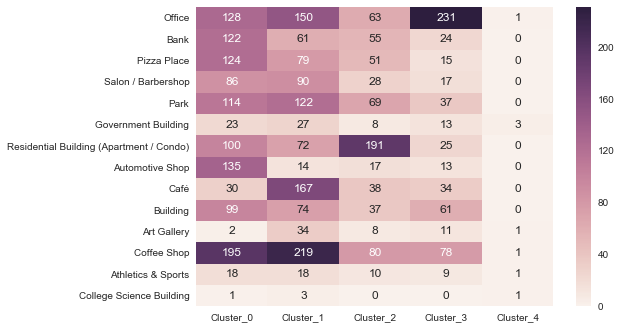

In [534]:
new_cols = []

for col in pop_categories_count.columns:
    col = 'Cluster_' + str(col)
    new_cols.append(col)

pop_categories_count.columns = new_cols

sns.heatmap(pop_categories_count.astype('int'), annot=True, fmt="d")
plt.show()

Below are the heatmap I've got and corresponding conclusions.

The heat map above may differ because clusters are named differently each time clustering is launched.

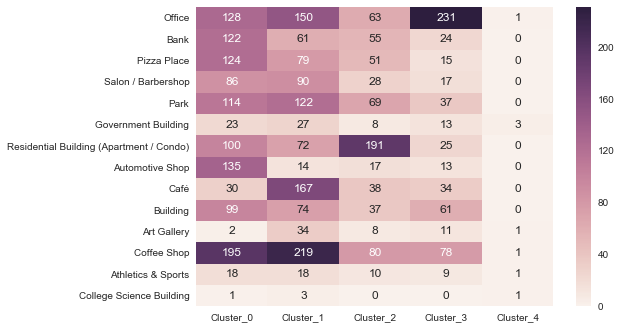

In [533]:
Image(filename='heat_map.png')

So, the **cluster 0** has a lot of coffee shops. It also has a fair amount of automotive shops, offices, pizzerias, banks, and parks. It doesn't have a lot of cafes. The corresponding areas must be business districts with developed recreational infrastructure. Let's name it **Work and play zone**

**Cluster 1** has many coffee shops as well, but also a lot of cafes and offices. It must include social and recreatonal areas people choose to go out to, spend time outdoors, shop etc. Let's name it **Going out zone**

**Cluster 2** consists of residential areas. It's clearly a **Residential zone**

**Cluster 3** is business districts. It's a **Business zone**

**Cluster 4** doesn't have a lot of venues, and majority are governmental facilities. Let's call it **Government zone**

___________________________________________________________________________________________________

Thank you for your attention.

Below are common venues for each neighborhood.

#### Cluster 0

In [510]:
c0 = toronto_merged.loc[toronto_merged['cluster_label'] == 0, toronto_merged.columns[[2] + list(range(3, toronto_merged.shape[1]))]]
c0

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
3,Woburn,43.769552,-79.217702,Coffee Shop,Convenience Store,Pizza Place,Building,Spa,Pharmacy,School,Salon / Barbershop,Residential Building (Apartment / Condo),Church,0
7,Downsview,43.733234,-79.512209,Vietnamese Restaurant,Coffee Shop,Residential Building (Apartment / Condo),Building,Park,Gas Station,Bank,Pizza Place,Office,Salon / Barbershop,0
90,Downsview,43.735312,-79.469089,Vietnamese Restaurant,Coffee Shop,Residential Building (Apartment / Condo),Building,Park,Gas Station,Bank,Pizza Place,Office,Salon / Barbershop,0
94,Downsview,43.757004,-79.520192,Vietnamese Restaurant,Coffee Shop,Residential Building (Apartment / Condo),Building,Park,Gas Station,Bank,Pizza Place,Office,Salon / Barbershop,0
95,Downsview,43.729618,-79.494955,Vietnamese Restaurant,Coffee Shop,Residential Building (Apartment / Condo),Building,Park,Gas Station,Bank,Pizza Place,Office,Salon / Barbershop,0
9,"Clarks Corners, Tam O'Shanter, Sullivan",43.780739,-79.304081,Chinese Restaurant,Gas Station,Doctor's Office,Bank,Coffee Shop,Dentist's Office,Fast Food Restaurant,Automotive Shop,Pharmacy,Road,0
15,"Mimico NW, The Queensway West, South of Bloor,...",43.626292,-79.519845,Coffee Shop,Restaurant,Fast Food Restaurant,Office,Miscellaneous Shop,Bakery,Automotive Shop,Sandwich Place,Gym / Fitness Center,BBQ Joint,0
18,Hillcrest Village,43.801961,-79.356633,College Classroom,Chinese Restaurant,Coffee Shop,Pizza Place,Medical Center,Park,Residential Building (Apartment / Condo),Japanese Restaurant,Bank,Furniture / Home Store,0
21,"Milliken, Agincourt North, Steeles East, L'Amo...",43.817514,-79.281876,Chinese Restaurant,Park,Coffee Shop,Doctor's Office,Pizza Place,Bakery,Building,Pharmacy,Bubble Tea Shop,Medical Center,0
27,"Runnymede, The Junction North",43.675423,-79.480426,Furniture / Home Store,Automotive Shop,Coffee Shop,Park,BBQ Joint,Brewery,Event Space,Bakery,Restaurant,Storage Facility,0


#### Cluster 1

In [514]:
c1 = toronto_merged.loc[toronto_merged['cluster_label'] == 1, toronto_merged.columns[[2] + list(range(3, toronto_merged.shape[1]))]]
c1.head()

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
2,"Runnymede, Swansea",43.649990,-79.479589,Park,Café,Office,Italian Restaurant,Dentist's Office,Grocery Store,Building,Salon / Barbershop,Miscellaneous Shop,Coffee Shop,1
4,Christie,43.668548,-79.420849,Café,Korean Restaurant,Road,Office,Grocery Store,Bakery,Coffee Shop,Ice Cream Shop,Design Studio,Karaoke Bar,1
6,The Beaches,43.678341,-79.294190,Pub,Coffee Shop,Doctor's Office,Breakfast Spot,Bank,Office,School,Japanese Restaurant,Grocery Store,Convenience Store,1
10,Church and Wellesley,43.666554,-79.381667,Coffee Shop,Residential Building (Apartment / Condo),Japanese Restaurant,Gay Bar,Sushi Restaurant,Café,Restaurant,Building,Salon / Barbershop,Beer Garden,1
14,"CN Tower, King and Spadina, Railway Lands, Har...",43.641304,-79.397055,Coffee Shop,Residential Building (Apartment / Condo),Gym,Café,Office,Salon / Barbershop,Park,Italian Restaurant,Yoga Studio,French Restaurant,1


#### Cluster 2

In [512]:
c2 = toronto_merged.loc[toronto_merged['cluster_label'] == 2, toronto_merged.columns[[2] + list(range(3, toronto_merged.shape[1]))]]
c2.head()

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
1,Bayview Village,43.777490,-79.380620,Residential Building (Apartment / Condo),Dentist's Office,Clothing Store,Bank,Park,Coffee Shop,Furniture / Home Store,Women's Store,Café,Shoe Store,2
8,Willowdale,43.768139,-79.408556,Residential Building (Apartment / Condo),Coffee Shop,Pizza Place,Bank,Park,Korean Restaurant,Medical Center,Pharmacy,Sandwich Place,Ramen Restaurant,2
48,Willowdale,43.779319,-79.443070,Residential Building (Apartment / Condo),Coffee Shop,Pizza Place,Bank,Park,Korean Restaurant,Medical Center,Pharmacy,Sandwich Place,Ramen Restaurant,2
11,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.632859,-79.496210,Residential Building (Apartment / Condo),Italian Restaurant,Salon / Barbershop,Convenience Store,School,Spa,Sandwich Place,Park,Road,Flower Shop,2
12,Forest Hill North & West,43.696669,-79.411794,Office,Residential Building (Apartment / Condo),Park,Italian Restaurant,General Entertainment,Tech Startup,Gym / Fitness Center,Sushi Restaurant,Gas Station,Coffee Shop,2


#### Cluster 3

In [513]:
c3 = toronto_merged.loc[toronto_merged['cluster_label'] == 3, toronto_merged.columns[[2] + list(range(3, toronto_merged.shape[1]))]]
c3.head()

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
0,"Commerce Court, Victoria Hotel",43.648165,-79.379390,Office,Salon / Barbershop,Bank,Building,Dentist's Office,Financial or Legal Service,Deli / Bodega,Bus Stop,Pharmacy,Sushi Restaurant,3
5,Upper Rouge,43.829676,-79.220536,Office,Road,Event Space,Factory,Building,Playground,Park,Bakery,Gym,Ski Area,3
22,"Richmond, Adelaide, King",43.649702,-79.384035,Office,Coffee Shop,Café,Food Court,Salon / Barbershop,Bank,Restaurant,Financial or Legal Service,Bar,Salad Place,3
24,Don Mills,43.745607,-79.358067,Office,Coffee Shop,Park,Japanese Restaurant,Restaurant,Building,Sandwich Place,Church,Italian Restaurant,School,3
42,Don Mills,43.725418,-79.340739,Office,Coffee Shop,Park,Japanese Restaurant,Restaurant,Building,Sandwich Place,Church,Italian Restaurant,School,3


#### Cluster 3

In [515]:
c4 = toronto_merged.loc[toronto_merged['cluster_label'] == 4, toronto_merged.columns[[2] + list(range(3, toronto_merged.shape[1]))]]
c4.head()

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster_label
47,"Queen's Park, Ontario Provincial Government",43.661921,-79.390262,Government Building,College Science Building,Coffee Shop,Light Rail Station,Track,General Entertainment,Athletics & Sports,Medical Lab,Office,Art Gallery,4


**END OF TASK THREE**